_________________________________________________________________________________________
## Task 5. Skiptrace (3pt)

Sherlock needs a team to defeat Professor Moriarty. Irene Adler recommended 3 reliable associates and provided 3 pictures of their last known whereabouts. Sherlock just needs to know their identities to be able to track them down.

Sherlock has a database of surveillance photos around NYC. He knows that these three associates definitely appear in these surveillance photos once.

Could you use these 3 query pictures provided by Irene Adler to figure out the names of pictures that contain our persons of interest? After you obtain the picture names, show these pictures to us in your report, and comment on the possibility of them defeating Professor Moriarty!

---

In [2]:
# Import Necessary Libraries
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize
import time

### Tips:

1. **Performance Expectations**:
   - This question can be time-consuming and memory-intensive. ------------->To give you some perspective of what to expect: It was tested on a laptop with **16GB of RAM** and a **Ryzen 9 5900HS CPU** (roughly equivalent to an Intel Core i7-11370H or i7-11375H), and it took about **50 minutes** to finish the whole thing.
   - **Start early** to account for the computational time required.

2. **Avoid Frequent Array Resizing**:
   - Avoid using `np.vstack()`, `np.hstack()`, or `np.concatenate()` too often.
   - Numpy arrays are designed in a way that frequently resizing them will be **time- and memory-consuming**.
   - Consider alternative options in Python when concatenating arrays is needed.
---

#### Understanding Keypoints, Descriptors, and Clustering with ORB

##### Keypoints and Descriptors

Given a picture, we detect **N keypoints**, and using **ORB** (Oriented FAST and Rotated BRIEF), we compute their **descriptors**. These descriptors are of size **(N × 32)**, where each number in the column represents an 8-bit binary value.

- A **row** in the descriptor matrix corresponds to the **flattened list of bits** derived from the pixel intensities in the **16 × 16 pixel neighborhood** around the keypoint.
- The **keypoint** is at the center of this 16 × 16 array, and the descriptor encodes the relative pixel patterns in this region.





Next, we use **K-Means clustering** to group these descriptors into **n clusters** of visual words, where **n ranges from 1 to 5** (both inclusive). Each cluster represents a group of descriptors with similar patterns.



1. Descriptors are assigned to clusters based on their **similarity** to a cluster centroid.
2. A **centroid** is the mean of the descriptors (in feature space) belonging to that cluster.



##### Formation of Visual Words

The visual words (clusters) are formed by grouping descriptors with similar patterns. The visual words are determined based on the **dispersion** of descriptor values (corresponding to pixel patterns) around the cluster centroids. 

- The **centroid** is calculated as the **mean position** of descriptors in the feature space, representing the central pattern of the cluster.


In [3]:
# Start the timer to measure computation time
start_time = time.time()

# Set paths for database and query images
database_path = 'database/'
query_path = 'query/'

# Parameters
n_clusters = 300  # Number of visual words
batch_size = 1000  # Batch size for MiniBatchKMeans

# Initialize the ORB detector once to avoid redundancy
orb = cv2.ORB_create()

In [4]:
# Function to extract ORB descriptors from an image
def extract_descriptors(image):
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return descriptors

In [5]:
# Generator function to yield descriptors from images in a directory
def descriptors_from_images(image_paths):
    for img_path in image_paths:
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            descriptors = extract_descriptors(image)
            if descriptors is not None and len(descriptors) > 0:
                yield descriptors

In [6]:
# Initialize MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size)

# Collect image paths
database_images = glob.glob(os.path.join(database_path, '*.jpg'))
query_images = glob.glob(os.path.join(query_path, '*.jpg'))

**Step 1** : Fit KMeans incrementally

In [7]:
# Fit KMeans with descriptors from database images incrementally
for descriptors in descriptors_from_images(database_images):
    kmeans.partial_fit(descriptors)

**Step 2**: Build histograms for database images

In [8]:
# Preallocate histograms
num_database_images = len(database_images)
histograms_database = np.zeros((num_database_images, n_clusters), dtype=np.float32)

for idx, img_path in enumerate(database_images):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        descriptors = extract_descriptors(image)
        if descriptors is not None and len(descriptors) > 0:
            clusters = kmeans.predict(descriptors)
            histogram, _ = np.histogram(clusters, bins=np.arange(n_clusters + 1))
            histograms_database[idx] = histogram

# Normalize histograms
histograms_database = normalize(histograms_database, norm='l2')

**Step 3**: Build histograms for query images

In [9]:
# Preallocate histograms
num_query_images = len(query_images)
histograms_query = np.zeros((num_query_images, n_clusters), dtype=np.float32)

for idx, img_path in enumerate(query_images):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        descriptors = extract_descriptors(image)
        if descriptors is not None and len(descriptors) > 0:
            clusters = kmeans.predict(descriptors)
            histogram, _ = np.histogram(clusters, bins=np.arange(n_clusters + 1))
            histograms_query[idx] = histogram

# Normalize histograms
histograms_query = normalize(histograms_query, norm='l2')

**Step 4**: Find nearest neighbors using k-NN

In [10]:
knn = NearestNeighbors(n_neighbors=1, algorithm='auto')
knn.fit(histograms_database)
distances, indices = knn.kneighbors(histograms_query)

**Step 5**: Display intruder images

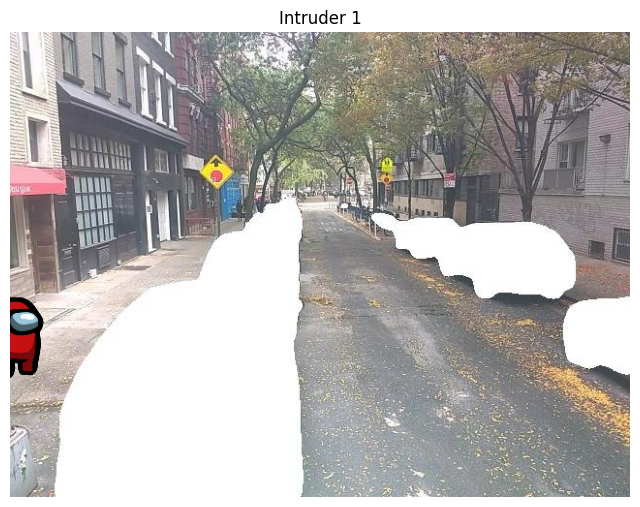

Intruder 1 is found in database/dr5rsn0yet6m-dr5rsn0ympkm-cds-3670f40ef7987d5a-20161022-1109-395.jpg


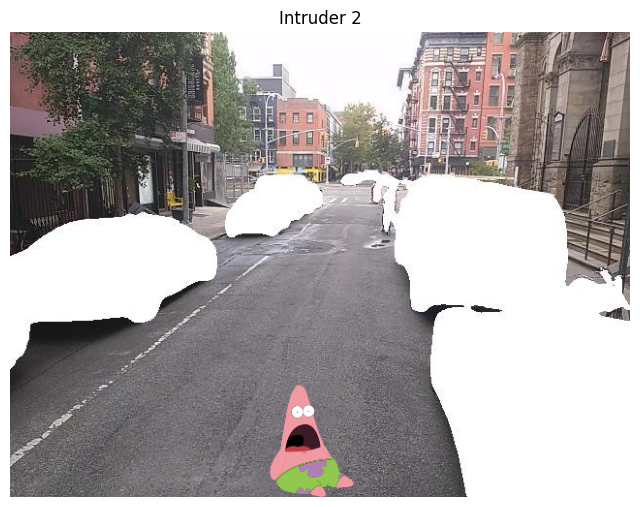

Intruder 2 is found in database/dr5rsn1w5bcx-dr5rsn1tuppy-cds-22ecab6d4a71bfcf-20160901-1157-7368.jpg


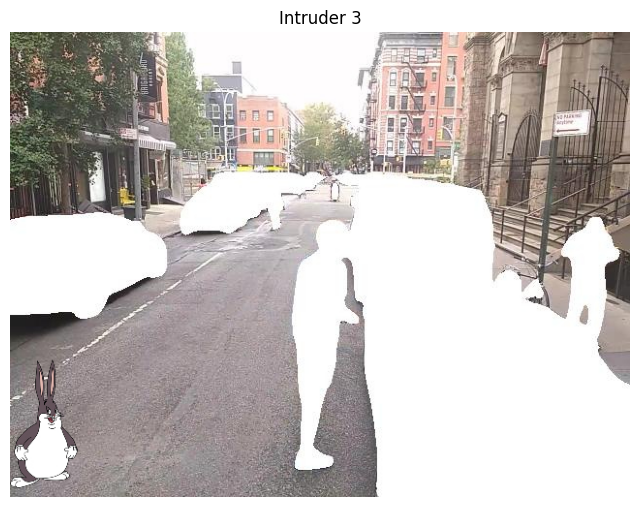

Intruder 3 is found in database/dr5rsn1tgm9f-dr5rsn1tggkn-cds-22ecab6d4a71bfcf-20160901-1157-7188.jpg
Total computation time: 177.68 seconds


In [11]:
# Map database indices to image paths
index_to_image_path = {idx: path for idx, path in enumerate(database_images)}

for idx, nearest_idx in enumerate(indices.flatten()):
    intruder_image_path = index_to_image_path[nearest_idx]
    intruder_image = cv2.cvtColor(cv2.imread(intruder_image_path), cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(intruder_image)
    plt.title(f'Intruder {idx + 1}')
    plt.axis('off')
    plt.show()

    print(f'Intruder {idx + 1} is found in {intruder_image_path}')

# End the timer and print the computation time
end_time = time.time()
print(f"Total computation time: {end_time - start_time:.2f} seconds")